In [1147]:
# Function to convert bounding box to polygon
import pandas as pd
import numpy as np
import pytest
from shapely.geometry import Polygon

def clean_string(s):
    import re
    # Replace all non-alphabetic characters with an empty string
    cleaned_string = re.sub(r'[^a-zA-Z]', '', s)
    # Convert the string to lowercase
    cleaned_string = cleaned_string.lower()
    return cleaned_string
    
def load_ac_data_spreadsheet(params):
    import pandas as pd
    data_labels = pd.read_csv(params["data_labels_path"])
    data_labels["data_labels_path"] = params["data_labels_path"]
    data_labels['images_folder'] = params["images_folder"]
    data_labels['num_ac'] = data_labels['ac_present'].str.extract(r"\(\s*(\d+)\s*\)").astype(float)
    

    # Fill NaN values with 0
    data_labels['num_ac'] = data_labels['num_ac'].fillna(0).infer_objects(copy=False)
    

    # Apply the function to the the right columns column
    for col in ['ac_present', 'ac_leaking', 'ac_discolored']:
        data_labels[col] = data_labels[col].astype(str)
        data_labels[col] = data_labels[col].apply(clean_string)
    
    data_labels['black1hot'] = data_labels['ac_discolored'].str.contains('black').astype(int)
    
    data_labels['white1hot'] = data_labels['ac_discolored'].str.contains('white').astype(int)
    
    data_labels['present1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)
    
    data_labels['leaking1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    data_labels['present_unknown1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)
    
    data_labels['leaking_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    data_labels['color_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    
    

    # Extract the numbers in brackets and convert them to integers
    assert data_labels.loc[data_labels['ac_present'] == 'yes', 'num_ac'].min() == 1
    return data_labels


def extract_label_data(label_set):
    rows = []
    for idx in range(0,len(label_set['projects'])):
        image_id = label_set['data_row'].iloc[idx]['external_id'] 
        # Iterate over each item in the data
        project_key = list(label_set['projects'][idx].keys())[0]
        for item in label_set['projects'][idx][project_key]['labels']:
            # Extract the necessary fields
            label_details = item['label_details']
            performance_details = item['performance_details']
            annotations = item['annotations']['objects']
            annotation_session_id = item['id']
        
            # Iterate over each annotation
            for annotation in annotations:
                # Create a dictionary for this row
                row = {
                    'feature_id' : annotation['feature_id'],
                    'annotation_session_id': annotation_session_id,
                    'image_id': image_id,
                    'worker': label_details['created_by'],
                    'seconds_to_create': performance_details['seconds_to_create'],
                    'annotation_kind': annotation['annotation_kind'],
                    'top': annotation['bounding_box']['top'],
                    'left': annotation['bounding_box']['left'],
                    'height': annotation['bounding_box']['height'],
                    'width': annotation['bounding_box']['width'],
                    'name': annotation['name'],
                    'value': annotation['value'],
                    
                    
                }
        
                # Append the row to the list
                rows.append(row)
        
        # Convert the list of rows into a DataFrame
        df = pd.DataFrame(rows)
    return df

def test_extract_label_data():
    # Define a sample label set
    label_set = {
        'projects': [
            {
                'project1': {
                    'labels': [
                        {
                            'label_details': {'created_by': 'worker1'},
                            'performance_details': {'seconds_to_create': 10},
                            'id': 'id1',
                            'annotations': {
                                
                                'objects': [
                                    {
                                        'feature_id': 'id1',
                                        'annotation_kind': 'kind1',
                                        'bounding_box': {'top': 0, 'left': 0, 'height': 10, 'width': 10},
                                        'name': 'name1',
                                        'value': 'value1'
                                    }
                                ]
                            }
                        }
                    ]
                }
            }
        ],
        'data_row': pd.DataFrame({'external_id': ['id1']})
    }

    # Call the function with the sample label set
    df = extract_label_data(label_set)

    # Define the expected DataFrame
    expected_df = pd.DataFrame({
        'feature_id': ['id1'],
        'annotation_session_id': ['id1'],
        'image_id': ['id1'],
        'worker': ['worker1'],
        'seconds_to_create': [10],
        'annotation_kind': ['kind1'],
        'top': [0],
        'left': [0],
        'height': [10],
        'width': [10],
        'name': ['name1'],
        'value': ['value1']
    })

    # Assert that the returned DataFrame is as expected
    pd.testing.assert_frame_equal(df, expected_df)

def bbox_to_polygon(row):
    left = row['left']
    top = row['top']
    right = left + row['width']
    bottom = top + row['height']
    return Polygon([(left, top), (right, top), (right, bottom), (left, bottom)])

def test_bbox_to_polygon():
    # Define a sample row
    row = {
        'left': 5,
        'top': 5,
        'width': 10,
        'height': 10
    }

    # Call the function with the sample row
    polygon = bbox_to_polygon(row)

    # Define the expected Polygon
    expected_polygon = Polygon([(5, 5), (15, 5), (15, 15), (5, 15)])

    # Assert that the returned Polygon is as expected
    assert polygon.equals(expected_polygon)

def calculate_iou(geom1, geom2):
    intersection = geom1.intersection(geom2).area
    union = geom1.union(geom2).area
    if union == 0:
        return 0  # Non-overlapping polygons
    return intersection / union

def test_calculate_iou():
    # Define two overlapping polygons
    polygon1 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
    polygon2 = Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)])

    # Calculate the IoU
    iou = calculate_iou(polygon1, polygon2)

    # Assert that the IoU is as expected
    assert pytest.approx(iou, 0.01) == (1.0/7)

    # Define two non-overlapping polygons
    polygon3 = Polygon([(2, 2), (3, 2), (3, 3), (2, 3)])

    # Calculate the IoU
    iou = calculate_iou(polygon1, polygon3)

    # Assert that the IoU is as expected
    assert iou == 0

def self_join_labels(df):
    paired_df = df[df.annotation_kind == 'ImageBoundingBox']
    paired_df = paired_df[['image_id','worker', 'geometry','name']]
    paired_df = pd.merge(paired_df.rename(columns={'worker': 'worker1', 'geometry': 'geometry1'}),
                      paired_df.rename(columns={'worker': 'worker2', 'geometry': 'geometry2'}),
                      on=['image_id','name'])
    
    # Filter to keep only pairs where worker1 < worker2
    paired_df = paired_df[paired_df['worker1'] < paired_df['worker2']].reset_index(drop=True)
    return paired_df


def test_self_join_labels():
    # Define a sample DataFrame
    df = pd.DataFrame({
        'image_id': ['id1', 'id1', 'id1'],
        'worker': ['w1', 'w1', 'w2'],
        'geometry': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]), Polygon([(2, 2), (3, 2), (3, 3), (2, 3)])],
        'name': ['n1', 'n1', 'n1'],
        'annotation_kind': ['ImageBoundingBox', 'ImageBoundingBox', 'ImageBoundingBox']
    })

    # Call the function with the sample DataFrame
    paired_df = self_join_labels(df)

    # Define the expected DataFrame
    expected_df = pd.DataFrame({
        'image_id': ['id1','id1'],
        'worker1': ['w1','w1'],
        'geometry1': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]),Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])],
        'name': ['n1','n1'],
        'worker2': ['w2','w2'],
        'geometry2': [Polygon([(2, 2), (3, 2), (3, 3), (2, 3)]),Polygon([(2, 2), (3, 2), (3, 3), (2, 3)])]
    })

    # Assert that the returned DataFrame is as expected
    pd.testing.assert_frame_equal(paired_df, expected_df)


# Step 2: Find the maximum IoUs for each worker-worker pair for each image_id and name
def process_matches(group):
    #Find pairs of geometries with the maximum IoU between worker1 and worker2 for each image and label_type. Only makes sense if only non-zero IoUs are passed in. These best matches are later used to find distinct sets for averaging
    results = []
    for (image_id, name, worker1, worker2), pair_group in group.groupby(['image_id', 'name', 'worker1', 'worker2']):
        used_geometries = set()
        
        while not pair_group.empty:
            # Find the maximum IoU
            max_iou_row = pair_group.loc[pair_group['iou'].idxmax()]
            
            
            results.append(max_iou_row)
            
            # Add the used geometries to the set
            used_geometries.add(max_iou_row['geometry1'])
            used_geometries.add(max_iou_row['geometry2'])
            
            # Remove rows with used geometries for this worker pair
            pair_group = pair_group[~(pair_group['geometry1'].isin(used_geometries) | 
                                      pair_group['geometry2'].isin(used_geometries))]
        #print('progress')
    return pd.DataFrame(results)

def test_process_matches():
    # Define a sample DataFrame
    df = pd.DataFrame({
        'image_id': ['id1', 'id1', 'id1', 'id1'],
        'name': ['name1', 'name1', 'name1', 'name1'],
        'worker1': ['worker1', 'worker1', 'worker1', 'worker1'],
        'worker2': ['worker2', 'worker2', 'worker2', 'worker2'],
        'geometry1': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(30, 30), (31, 30), (31, 31), (30, 31)])],
        'geometry2': [Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)]), Polygon([(50, 50), (52, 50), (52, 52), (50, 52)]), Polygon([(72, 72), (73, 72), (73, 73), (72, 73)]), Polygon([(30, 30), (31, 30), (31, 31), (30, 31)])],
        'iou': [1.0/7, 0, 0, 1]
    })

    # Call the function with the sample DataFrame
    grouped = df.groupby(['image_id','name', 'worker1', 'worker2'])
    processed_df = grouped[['image_id','name', 'worker1', 'worker2','geometry1','geometry2','iou']].apply(process_matches).reset_index(drop=True)

    # Define the expected DataFrame
    expected_df = pd.DataFrame({
        'image_id': ['id1','id1'],
        'name': ['name1','name1'],
        'worker1': ['worker1','worker1'],
        'worker2': ['worker2','worker2'],
        'geometry1': [Polygon([(30, 30), (31, 30), (31, 31), (30, 31)]),Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])],
        'geometry2': [Polygon([(30, 30), (31, 30), (31, 31), (30, 31)]),Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)])],
        'iou': [1,1.0/7]
    })

    # Assert that the returned DataFrame is as expected
    pd.testing.assert_frame_equal(processed_df, expected_df)

def find_sets(pairs):
    # Find connected sets of geometries
    sets = []
    for pair in pairs:
        found = False
        for s in sets:
            if pair[0] in s or pair[1] in s:
                s.add(pair[0])
                s.add(pair[1])
                found = True
                break
        if not found:
            sets.append({pair[0], pair[1]})
    return sets

def test_find_sets():
    # Define a sample list of pairs
    pairs = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8)]

    # Call the function with the sample list of pairs
    sets = find_sets(pairs)

    # Define the expected list of sets
    expected_sets = [{1, 2, 3}, {4, 5, 6}, {7, 8}]

    # Assert that the returned list of sets is as expected
    assert sets == expected_sets

def filter_matched_boxes(matched_boxes, min_matches_per_image = 3):
    # keep only the matched boxes where there are at least n matches per image, name, worker, worker geometry
    

    matched_boxes['geo_str1'] = matched_boxes['geometry1'].apply(lambda x: str(x))
    matched_boxes['geo_str2'] = matched_boxes['geometry2'].apply(lambda x: str(x))
    keeper_geometries  = pd.concat([matched_boxes[['image_id','name','worker1','geo_str1']].rename(columns={'worker1': 'worker','geo_str1': 'geo_str'}),matched_boxes[['image_id','name','worker2','geo_str2']].rename(columns={'worker2': 'worker','geo_str2': 'geo_str'})], axis = 0)
    # Find all the geometries where there are at least 3 matches for a given geometry
    keeper_size = keeper_geometries.groupby(['image_id','name','worker','geo_str']).size().rename('num_matches') + 1
    keeper_size = keeper_size[keeper_size >=(min_matches_per_image)]
    
    matched_boxes = matched_boxes.merge(keeper_size.to_frame(), left_on = ['image_id','name','worker1','geo_str1'], right_on = ['image_id','name','worker','geo_str'], how = 'inner')
    
    matched_boxes = matched_boxes.merge(keeper_size.to_frame().drop('num_matches',axis = 1), left_on = ['image_id','name','worker2','geo_str2'], right_on = ['image_id','name','worker','geo_str'], how = 'inner')
    
    return matched_boxes


def test_filter_matched_boxes():
    #Needs implementation
    print('test_filter_matched_boxes Not implemented')
    
def average_polygon(polygons):
    # Calculate the average coordinates for each point
    avg_coords = [
        (sum(polygon.exterior.coords[i][0] for polygon in polygons) / len(polygons),
         sum(polygon.exterior.coords[i][1] for polygon in polygons) / len(polygons))
        for i in range(5)  # 5 points in the polygon
    ]
    avg_coords = np.round(avg_coords, 0)
    # Create a new polygon using the average coordinates
    avg_polygon = Polygon(avg_coords)

    return avg_polygon

def test_average_polygon():
    #Needs implementation
    print('test_average_polygon Not implemented')    
 
def do_any_sets_intersect(sets):
    # Iterate over each pair of sets
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            # If the intersection is not empty
            if sets[i] & sets[j]:
                return True
    return False

def test_do_any_sets_intersect():
    #Needs implementation
    print('test_do_any_sets_intersect Not implemented')   
    
    
def label_annotation_sets(df, connected_sets, annotators_per_image):
    #Find all of the unique annotation locations and give a set order, count the number of annotators that contributed to that set, average the annotations for each set
    df_cs = pd.merge(df, connected_sets, on = ['image_id','name'], how = 'outer')
    df_cs['connected_sets'] = df_cs.apply(lambda x: x['connected_sets'] if x['connected_sets'] is not np.nan else [{}], axis = 1)
    df_cs['is_in_set'] = df_cs.apply(lambda x: np.array([int(x['geometry'] in x['connected_sets'][cnt]) for cnt in range(len(x['connected_sets']))]), axis = 1)
    grouped = df_cs.groupby(['image_id','name'])
    set_agreement = grouped['is_in_set'].apply(lambda x: np.sum(x)).rename('num_agree_in_set').reset_index()
    set_agreement['set_order'] = set_agreement['num_agree_in_set'].apply(lambda x: list(range(len(x))))
    sa = set_agreement.explode(['set_order','num_agree_in_set']).reset_index(drop=True)
    cs = connected_sets.to_frame()
    cs['set_order'] = cs['connected_sets'].apply(lambda x: list(range(len(x))))
    cs = cs.explode(['connected_sets','set_order']).reset_index(drop=False)
    matched_sets = pd.merge(sa,cs, on = ['image_id','name','set_order'], how = 'inner')
    matched_sets = matched_sets.reset_index().rename(columns = {'index': 'image_name_index'})
    matched_sets['averaged_polygons'] = matched_sets['connected_sets'].apply(lambda x: average_polygon(x))
    matched_sets['percent_agreement'] = matched_sets['num_agree_in_set']/annotators_per_image*100
    # Find image_id, annotation types where sets intersect (should be rare, find the offending labels that are causing the intersection and remove at the feature_id level
    intersecting_sets = connected_sets[connected_sets.apply(lambda x: do_any_sets_intersect(x))]
    
    
    for min_matches_per_image in range(2,annotators_per_image+1):
        filt_connected_sets = matched_sets[matched_sets['num_agree_in_set'] >= min_matches_per_image]
        print('Number of detected objects with min agreement threshold set to ' + str(min_matches_per_image/annotators_per_image*100) + ' percent:')
        print(filt_connected_sets.groupby('name').size())
    
    print('Number of intersecting sets: ' + str(len(intersecting_sets)))
    print('First average polygon :' + str(average_polygon(connected_sets.iloc[0][0])))
    return matched_sets
    
def mask_images_by_box(params):
    import cv2
    import os
    import numpy as np
    os.makedirs(params["images_folder"]+'_bounding_boxes', exist_ok=True)
    # Set default values for parameters if they are not provided
    if 'image_ids' not in params:
        data_labels = load_ac_data_labels(params)
        params["image_ids"] = data_labels["image_id"]
    if 'hsv_range' not in params:
        params['hsv_range'] = [[8, 120, 200], [12, 255, 255]]
    if 'kernal' not in params:
        params['kernal'] = np.ones((20,20), np.uint8)
    if 'min_bb_area' not in params:
        params['min_bb_area'] = 1
    if 'max_bb_area' not in params:
        params['max_bb_area'] = 1000000000
    if 'min_ratio' not in params:
        params['min_ratio'] = 1.0
    image_df = pd.DataFrame(columns= ['image_id', 'image_path','x', 'y', 'w', 'h'])
    for image_id in params['image_ids']:  
        image_path = os.path.join(params['images_folder'], image_id)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find the orange bounding box in the image
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if params['hsv_range'] is not None:
            lower_orange = np.array(params['hsv_range'][0])
            upper_orange = np.array(params['hsv_range'][1])
            mask = cv2.inRange(hsv, lower_orange, upper_orange)
        else:
            mask = cv2.inRange(hsv, np.array([0,0,0]),np.array([180,255,255])) #no filter
    
        
        # Perform dilation on the mask to close small gaps
        if params['kernal'] is not None:
            kernel = params['kernal']
            mask = cv2.dilate(mask, kernel, iterations=2)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #print(np.size(image))
        # Function to find the contour with the highest perimeter-to-area ratio
        def find_hollow_box(contours, mask, params):
            hollow_contours = []
            for contour in contours:
                # Get the bounding rectangle of the largest rectangular contour
                x, y, w, h = cv2.boundingRect(contour)
                # Crop the mask around the bounding rectangle
                cropped_mask = mask[y:y+h, x:x+w]
                mask_area = cv2.countNonZero(cropped_mask)
                bb_area = w*h
    
                if mask_area > 0:
                    ratio = bb_area / mask_area
                    if ratio > params['min_ratio'] and bb_area > params['min_bb_area'] and bb_area < params['max_bb_area']:
                        hollow_contours.append(contour)
                        #print('ratio:' + str(ratio) + ' bb_area:' + str(bb_area) + ' mask_area:' + str(mask_area) + ' of image ' + image_id)
                         
            return hollow_contours  
        # Find the contour that best matches a hollow box
        contours = find_hollow_box(contours, mask, params)
        if contours == []:
            print(f'No bounding box found for image {image_id}')
            continue
            tmp = pd.DataFrame({'image_id': image_id, 'image_path': image_path, 'x': 0, 'y': 0, 'w': 0, 'h': 0}, index = [0])
            image_df = pd.concat([image_df, tmp], axis = 0, ignore_index=True)
        else:
            # Find the largest rectangular contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Get the bounding rectangle of the largest rectangular contour
            x, y, w, h = cv2.boundingRect(largest_contour)
            # Crop the image around the bounding rectangle
            cropped_image = image[y:y+h, x:x+w]
            tmp = pd.DataFrame({'image_id': image_id, 'image_path': image_path, 'x': x, 'y': y, 'w': w, 'h': h}, index = [0])
            image_df = pd.concat([image_df, tmp], axis = 0, ignore_index=True)
            
    return image_df 

test_calculate_iou()
test_extract_label_data()
test_self_join_labels()
test_bbox_to_polygon()
test_process_matches()
test_find_sets()
test_filter_matched_boxes()
test_average_polygon()
test_do_any_sets_intersect()

test_filter_matched_boxes Not implemented
test_average_polygon Not implemented
test_do_any_sets_intersect Not implemented


In [496]:
params = {}
#params['category_index_column'] = "present1hot"
params['category_labels'] = ['No', 'Yes']
params['images_folder'] = '../data/images/ac_150'
params["data_labels_path"] = '../data/labels/ac_150_labels_jess_notes.csv'

prime_labels = load_ac_data_spreadsheet(params)

In [1149]:
# Load in the data labels
annotation_path = '../data/labels/Export v2 project - AC Unit Evaluation Test - 7_3_2024.ndjson'

iou_threshold = (1.0/3)
annotators_per_image = 5


label_set = pd.read_json(annotation_path, lines=True)
df = extract_label_data(label_set)

#remove intersecting bounding box
df = df[df['feature_id'] != 'clxgcq78i00hx3b6qit987ryb']

df['geometry'] = df.apply(bbox_to_polygon, axis=1)
paired_df = self_join_labels(df)
paired_df['iou'] = paired_df.apply(lambda row: calculate_iou(row['geometry1'], row['geometry2']), axis=1)
paired_df = paired_df[['image_id', 'name','worker1', 'worker2', 'geometry1', 'geometry2', 'iou']]
paired_df = paired_df[paired_df['iou'] > iou_threshold]

grouped = paired_df.groupby(['image_id','name', 'worker1', 'worker2'])
matched_boxes = grouped[['image_id','name', 'worker1', 'worker2','geometry1','geometry2','iou']].apply(process_matches).reset_index(drop=True)

grouped = matched_boxes.groupby(['image_id','name'])
connected_sets = (grouped[['image_id', 'name', 'worker1', 'worker2', 'geometry1','geometry2', 'iou']].apply(lambda x: find_sets(list(zip(x['geometry1'],x['geometry2'])))).rename('connected_sets'))


matched_sets = label_annotation_sets(df, connected_sets, annotators_per_image)

Number of detected objects with min agreement threshold set to 40.0 percent:
name
AC Unit       292
AC leaking     94
dtype: int64
Number of detected objects with min agreement threshold set to 60.0 percent:
name
AC Unit       275
AC leaking     72
dtype: int64
Number of detected objects with min agreement threshold set to 80.0 percent:
name
AC Unit       266
AC leaking     63
dtype: int64
Number of detected objects with min agreement threshold set to 100.0 percent:
name
AC Unit       242
AC leaking     41
dtype: int64
Number of intersecting sets: 0
First average polygon :POLYGON ((843 577, 867 577, 867 613, 843 613, 843 577))


In [1150]:
params = {}
params['images_folder'] = '../data/images/ac_150_images'
params["image_ids"] = prime_labels['image_id']
mask_df = mask_images_by_box(params)

# turn columns x,y,w,h in shapely polygons
mask_df['mask_geometry'] = mask_df.apply(lambda row: box(row['x'], row['y'], row['x']+row['w'], row['y']+row['h']), axis=1)
mask_df['mask_geometry'] = mask_df['mask_geometry'].apply(lambda x: Polygon(x.exterior.coords))
full_train = pd.merge(matched_sets, mask_df, on = 'image_id', how = 'inner')

In [1151]:
full_train

,image_name_index,image_id,name,num_agree_in_set,set_order,connected_sets,averaged_polygons,percent_agreement,image_path,x,y,w,h,mask_geometry
0,0,005FFFAE-CEE1-4488-95D3-E3289B389128.jpeg,AC Unit,5,0,"{POLYGON ((845 574, 867 574, 867 613, 845 613,...","POLYGON ((843 577, 867 577, 867 613, 843 613, ...",100.0,../data/images/ac_150_images/005FFFAE-CEE1-448...,672,456,316,290,"POLYGON ((988 456, 988 746, 672 746, 672 456, ..."
1,1,005FFFAE-CEE1-4488-95D3-E3289B389128.jpeg,AC leaking,4,0,"{POLYGON ((819 578, 868 578, 868 615, 819 615,...","POLYGON ((821 576, 867 576, 867 614, 821 614, ...",80.0,../data/images/ac_150_images/005FFFAE-CEE1-448...,672,456,316,290,"POLYGON ((988 456, 988 746, 672 746, 672 456, ..."
2,2,009FAA0F-631C-4A13-BFE6-678B24DE0044.jpeg,AC Unit,5,0,"{POLYGON ((706 397, 749 397, 749 440, 706 440,...","POLYGON ((709 398, 748 398, 748 439, 709 439, ...",100.0,../data/images/ac_150_images/009FAA0F-631C-4A1...,415,244,519,532,"POLYGON ((934 244, 934 776, 415 776, 415 244, ..."
3,3,009FAA0F-631C-4A13-BFE6-678B24DE0044.jpeg,AC Unit,5,1,"{POLYGON ((732 620, 770 620, 770 654, 732 654,...","POLYGON ((732 621, 770 621, 770 655, 732 655, ...",100.0,../data/images/ac_150_images/009FAA0F-631C-4A1...,415,244,519,532,"POLYGON ((934 244, 934 776, 415 776, 415 244, ..."
4,4,009FAA0F-631C-4A13-BFE6-678B24DE0044.jpeg,AC Unit,5,2,"{POLYGON ((781 461, 813 461, 813 495, 781 495,...","POLYGON ((781 460, 813 460, 813 496, 781 496, ...",100.0,../data/images/ac_150_images/009FAA0F-631C-4A1...,415,244,519,532,"POLYGON ((934 244, 934 776, 415 776, 415 244, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,381,FB0C8388-3E55-4066-A900-7C3C72A33158.jpeg,AC Unit,5,0,"{POLYGON ((985 356, 1018 356, 1018 380, 985 38...","POLYGON ((984 356, 1015 356, 1015 380, 984 380...",100.0,../data/images/ac_150_images/FB0C8388-3E55-406...,857,214,316,410,"POLYGON ((1173 214, 1173 624, 857 624, 857 214..."
382,382,FB0C8388-3E55-4066-A900-7C3C72A33158.jpeg,AC leaking,5,0,"{POLYGON ((948 357, 1012 357, 1012 387, 948 38...","POLYGON ((948 356, 1015 356, 1015 388, 948 388...",100.0,../data/images/ac_150_images/FB0C8388-3E55-406...,857,214,316,410,"POLYGON ((1173 214, 1173 624, 857 624, 857 214..."
383,383,FD8A3406-B6C5-4F6B-8330-EF11CB8DE500.jpeg,AC Unit,5,0,"{POLYGON ((1156 863, 1183 863, 1183 894, 1156 ...","POLYGON ((1157 863, 1183 863, 1183 894, 1157 8...",100.0,../data/images/ac_150_images/FD8A3406-B6C5-4F6...,836,683,678,399,"POLYGON ((1514 683, 1514 1082, 836 1082, 836 6..."
384,384,FF43BB35-656F-48AD-BF15-B8B5A6244014.jpeg,AC Unit,5,0,"{POLYGON ((390 257, 421 257, 421 291, 390 291,...","POLYGON ((390 257, 420 257, 420 291, 390 291, ...",100.0,../data/images/ac_150_images/FF43BB35-656F-48A...,236,102,345,350,"POLYGON ((581 102, 581 452, 236 452, 236 102, ..."


In [1002]:
#May be greater than 100 you have intersecting sets, need to resolve with filter
agree_bin = matched_sets.groupby(['name','percent_agreement']).size().rename('count').reset_index().join(matched_sets.groupby(['name']).size().rename('total'), on = 'name')
agree_bin['percent_total'] = agree_bin['count']/agree_bin['total']*100
print(agree_bin)


         name  percent_agreement  count  total  percent_total
0     AC Unit               40.0     17    292       5.821918
1     AC Unit               60.0      9    292       3.082192
2     AC Unit               80.0     24    292       8.219178
3     AC Unit              100.0    242    292      82.876712
4  AC leaking               40.0     22     94      23.404255
5  AC leaking               60.0      9     94       9.574468
6  AC leaking               80.0     22     94      23.404255
7  AC leaking              100.0     41     94      43.617021


In [1006]:
labeler_df = matched_sets.copy(deep = True)

In [1034]:
averaged_polygons


,image_name_index,image_id,name,num_agree_in_set,set_order,connected_sets,averaged_polygons,percent_agreement
0,0,005FFFAE-CEE1-4488-95D3-E3289B389128.jpeg,AC Unit,5,0,"{POLYGON ((845 574, 867 574, 867 613, 845 613,...","POLYGON ((843 577, 867 577, 867 613, 843 613, ...",100.0
1,1,005FFFAE-CEE1-4488-95D3-E3289B389128.jpeg,AC leaking,4,0,"{POLYGON ((819 578, 868 578, 868 615, 819 615,...","POLYGON ((821 576, 867 576, 867 614, 821 614, ...",80.0
2,2,009FAA0F-631C-4A13-BFE6-678B24DE0044.jpeg,AC Unit,5,0,"{POLYGON ((706 397, 749 397, 749 440, 706 440,...","POLYGON ((709 398, 748 398, 748 439, 709 439, ...",100.0
3,3,009FAA0F-631C-4A13-BFE6-678B24DE0044.jpeg,AC Unit,5,1,"{POLYGON ((732 620, 770 620, 770 654, 732 654,...","POLYGON ((732 621, 770 621, 770 655, 732 655, ...",100.0
4,4,009FAA0F-631C-4A13-BFE6-678B24DE0044.jpeg,AC Unit,5,2,"{POLYGON ((781 461, 813 461, 813 495, 781 495,...","POLYGON ((781 460, 813 460, 813 496, 781 496, ...",100.0
...,...,...,...,...,...,...,...,...
381,381,FB0C8388-3E55-4066-A900-7C3C72A33158.jpeg,AC Unit,5,0,"{POLYGON ((985 356, 1018 356, 1018 380, 985 38...","POLYGON ((984 356, 1015 356, 1015 380, 984 380...",100.0
382,382,FB0C8388-3E55-4066-A900-7C3C72A33158.jpeg,AC leaking,5,0,"{POLYGON ((948 357, 1012 357, 1012 387, 948 38...","POLYGON ((948 356, 1015 356, 1015 388, 948 388...",100.0
383,383,FD8A3406-B6C5-4F6B-8330-EF11CB8DE500.jpeg,AC Unit,5,0,"{POLYGON ((1156 863, 1183 863, 1183 894, 1156 ...","POLYGON ((1157 863, 1183 863, 1183 894, 1157 8...",100.0
384,384,FF43BB35-656F-48AD-BF15-B8B5A6244014.jpeg,AC Unit,5,0,"{POLYGON ((390 257, 421 257, 421 291, 390 291,...","POLYGON ((390 257, 420 257, 420 291, 390 291, ...",100.0


In [1055]:
worker_has_polygon = df[['image_id', 'name', 'worker']].drop_duplicates()
worker_has_polygon['ind_worker_label'] = int(1)
worker_has_polygon['cross_join'] = 1

labeler_df = connected_sets.copy(deep = True)
comp_to_prime = labeler_df.reset_index(drop=False)
comp_to_prime['labeler_consensus'] = 1
ac_comp = comp_to_prime[comp_to_prime['name'] == 'AC Unit']
ac_comp = pd.merge(ac_comp, prime_labels[['image_id','present1hot']], on = ['image_id'], how = 'outer').rename(columns = {'present1hot': 'prime_label'})
ac_comp['name'] = 'AC Unit'
#ac_comp['averaged_polygons'] = ac_comp['averaged_polygons'].fillna(0)
leak_comp = comp_to_prime[comp_to_prime['name'] == 'AC leaking']
leak_comp = pd.merge(leak_comp, prime_labels[['image_id','leaking1hot']], on = ['image_id'], how = 'outer').rename(columns = {'leaking1hot': 'prime_label'})
leak_comp['name'] = 'AC leaking'
#leak_comp['averaged_polygons'] = leak_comp['averaged_polygons'].fillna(0)
comp_to_prime = pd.concat([ac_comp,leak_comp],axis=0,ignore_index=True)
comp_to_prime['labeler_consensus'] = comp_to_prime['labeler_consensus'].fillna(0)

comp_to_prime['match'] = (comp_to_prime['prime_label'] == comp_to_prime['labeler_consensus']).astype(int)

comp_to_prime['hit'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['correct_rejection'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['false_alarm'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['miss'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['cross_join'] = 1

worker_comp_to_prime = pd.merge(comp_to_prime, worker_has_polygon[['worker','cross_join']].drop_duplicates(), on = ['cross_join'], how = 'outer').fillna(0)
comp_to_prime = comp_to_prime.drop(columns = ['cross_join']).fillna(0)
worker_comp_to_prime = worker_comp_to_prime.drop(columns = ['cross_join'])
worker_has_polygon = worker_has_polygon.drop(columns = ['cross_join'])

worker_comp_to_prime = pd.merge(worker_comp_to_prime, worker_has_polygon, on = ['image_id','name','worker'], how = 'outer').fillna(0)

NameError: name 'connect_sets' is not defined

In [1052]:
comp_to_prime[comp_to_prime['match'] != 1]

,index,image_name_index,image_id,name,num_agree_in_set,set_order,connected_sets,averaged_polygons,percent_agreement,labeler_consensus,prime_label,match,hit,correct_rejection,false_alarm,miss
10,11.0,11.0,092A57CD-4201-4390-94A7-B8CF81185D81.jpeg,AC Unit,2,0,"{POLYGON ((549 580, 568 580, 568 598, 549 598,...","POLYGON ((550 580, 568 580, 568 598, 550 598, ...",40.0,1.0,0,0,0,0,1,0
16,18.0,18.0,12A3CEDF-A3EA-4AA5-A79C-6BBEA0669D40.jpeg,AC Unit,2,0,"{POLYGON ((983 642, 998 642, 998 656, 983 656,...","POLYGON ((983 642, 998 642, 998 656, 983 656, ...",40.0,1.0,0,0,0,0,1,0
47,58.0,58.0,2EAF3C2A-6532-40ED-8A09-EE046518A58D.jpeg,AC Unit,2,0,"{POLYGON ((962 643, 977 643, 977 661, 962 661,...","POLYGON ((962 642, 977 642, 977 661, 962 661, ...",40.0,1.0,0,0,0,0,1,0
69,81.0,81.0,46AB8983-9433-49A2-A1E6-FCA76B816FEC.jpeg,AC Unit,4,0,"{POLYGON ((404 258, 418 258, 418 279, 404 279,...","POLYGON ((403 258, 418 258, 418 279, 403 279, ...",80.0,1.0,0,0,0,0,1,0
81,92.0,92.0,5FEF3700-D42B-4FA4-83D2-2A2F82DAF3E7.jpeg,AC Unit,2,0,"{POLYGON ((885 473, 900 473, 900 490, 885 490,...","POLYGON ((885 474, 900 474, 900 492, 885 492, ...",40.0,1.0,0,0,0,0,1,0
82,93.0,93.0,5FEF3700-D42B-4FA4-83D2-2A2F82DAF3E7.jpeg,AC Unit,2,1,"{POLYGON ((990 505, 1002 505, 1002 521, 990 52...","POLYGON ((989 504, 1002 504, 1002 521, 989 521...",40.0,1.0,0,0,0,0,1,0
94,103.0,103.0,7315622D-5A26-49BF-BD74-B4C4858E480E.jpeg,AC Unit,2,0,"{POLYGON ((1105 368, 1128 368, 1128 391, 1105 ...","POLYGON ((1105 368, 1128 368, 1128 392, 1105 3...",40.0,1.0,0,0,0,0,1,0
95,104.0,104.0,7315622D-5A26-49BF-BD74-B4C4858E480E.jpeg,AC Unit,2,1,"{POLYGON ((915 599, 931 599, 931 616, 915 616,...","POLYGON ((914 599, 930 599, 930 616, 914 616, ...",40.0,1.0,0,0,0,0,1,0
199,230.0,230.0,B98CB789-7D75-4320-B483-30652E870754.jpeg,AC Unit,4,0,"{POLYGON ((775 616, 795 616, 795 638, 775 638,...","POLYGON ((774 616, 795 616, 795 638, 774 638, ...",80.0,1.0,0,0,0,0,1,0
262,302.0,302.0,DA2750B1-B30B-46B0-8DE3-6EA0E1CB43C4.jpeg,AC Unit,3,0,"{POLYGON ((921 347, 1011 347, 1011 361, 921 36...","POLYGON ((919 347, 1011 347, 1011 364, 919 364...",60.0,1.0,0,0,0,0,1,0


In [643]:
# print('Percentage: ')
# print(comp_to_prime.groupby(['name']).mean(['match','hit','correct_rejection','false_alarm','miss']))

# print('Sum: ')
# print(comp_to_prime.groupby(['name']).sum(['match','hit','correct_rejection','false_alarm','miss']))

In [1053]:
confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC Unit'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

print(confusion_matrix)

Predicted  0.0  1.0  All
True                    
0           37   15   52
1            0  277  277
All         37  292  329


In [1054]:
confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC leaking'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

print(confusion_matrix)

Predicted  0.0  1.0  All
True                    
0           99   16  115
1            1   78   79
All        100   94  194


In [1041]:
worker_comp_to_prime['worker'].unique()

array(['bguardado579@gmail.com', 'brenpineda2016@gmail.com',
       'carlosernestopinedacastro@gmail.com', 'jsigfredo.la77@gmail.com',
       'wendy16wrgp@gmail.com'], dtype=object)

In [1042]:
'labeler_consensus'

'labeler_consensus'

KeyError: 'percent_agreement'

In [1045]:
for worker in worker_comp_to_prime['worker'].unique(): 
    comp_filt = ((worker_comp_to_prime['name'] == 'AC Unit') & (worker_comp_to_prime['worker'] == worker))
    confusion_matrix = pd.crosstab(worker_comp_to_prime.loc[comp_filt,'prime_label'], worker_comp_to_prime.loc[(worker_comp_to_prime['worker'] == worker),'ind_worker_label'], rownames=['True'], colnames=['Predicted'], margins=True)

    print(worker + ': ')
    print(confusion_matrix)
    print(' ')

bguardado579@gmail.com: 
Predicted  0.0  1.0  All
True                    
0           39    7   46
1            0  104  104
All         39  111  150
 
brenpineda2016@gmail.com: 
Predicted  0.0  1.0  All
True                    
0           33   13   46
1            1  103  104
All         34  116  150
 
carlosernestopinedacastro@gmail.com: 
Predicted  0.0  1.0  All
True                    
0           44    2   46
1            1  103  104
All         45  105  150
 
jsigfredo.la77@gmail.com: 
Predicted  0.0  1.0  All
True                    
0           43    3   46
1            3  101  104
All         46  104  150
 
wendy16wrgp@gmail.com: 
Predicted  0.0  1.0  All
True                    
0           40    6   46
1            1  103  104
All         41  109  150
 


In [1046]:
for worker in worker_comp_to_prime['worker'].unique(): 
    comp_filt = ((worker_comp_to_prime['name'] == 'AC leaking') & (worker_comp_to_prime['worker'] == worker))
    confusion_matrix = pd.crosstab(worker_comp_to_prime.loc[comp_filt,'prime_label'], worker_comp_to_prime.loc[(worker_comp_to_prime['worker'] == worker),'ind_worker_label'], rownames=['True'], colnames=['Predicted'], margins=True)

    print(worker + ': ')
    print(confusion_matrix)
    print(' ')

bguardado579@gmail.com: 
Predicted  0.0  1.0  All
True                    
0          101    8  109
1            5   36   41
All        106   44  150
 
brenpineda2016@gmail.com: 
Predicted  0.0  1.0  All
True                    
0           96   13  109
1            4   37   41
All        100   50  150
 
carlosernestopinedacastro@gmail.com: 
Predicted  0.0  1.0  All
True                    
0          106    3  109
1            2   39   41
All        108   42  150
 
jsigfredo.la77@gmail.com: 
Predicted  0.0  1.0  All
True                    
0          101    8  109
1            7   34   41
All        108   42  150
 
wendy16wrgp@gmail.com: 
Predicted  0.0  1.0  All
True                    
0          103    6  109
1            6   35   41
All        109   41  150
 


In [1047]:
confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC leaking'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

print(confusion_matrix)

Predicted  0.0  1.0  All
True                    
0           99   10  109
1            1   40   41
All        100   50  150


In [1048]:
def calculate_f1_score(confusion_matrix):
    # Calculate precision and recall from the confusion matrix
    TruePositives = confusion_matrix[1][1]
    FalsePositives = confusion_matrix[0][1]
    FalseNegatives = confusion_matrix[1][0]

    precision = TruePositives / (TruePositives + FalsePositives)
    recall = TruePositives / (TruePositives + FalseNegatives)

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

# Assuming 'confusion_matrix' is the confusion matrix you have calculated
f1_score = calculate_f1_score(confusion_matrix)
print(f1_score)

0.8791208791208791


In [1049]:
43/46


0.9347826086956522

In [1059]:
worker_has_polygon = df[['image_id', 'name', 'worker']].drop_duplicates()
worker_has_polygon['ind_worker_label'] = int(1)
worker_has_polygon['cross_join'] = 1

labeler_df = matched_sets.copy(deep = True)
comp_to_prime = labeler_df.reset_index(drop=False)
comp_to_prime['labeler_consensus'] = 1
ac_comp = comp_to_prime[comp_to_prime['name'] == 'AC Unit']
ac_comp = pd.merge(ac_comp, prime_labels[['image_id','present1hot']], on = ['image_id'], how = 'outer').rename(columns = {'present1hot': 'prime_label'}).fillna(0)
ac_comp['name'] = 'AC Unit'
#ac_comp['averaged_polygons'] = ac_comp['averaged_polygons'].fillna(0)
leak_comp = comp_to_prime[comp_to_prime['name'] == 'AC leaking']
leak_comp = pd.merge(leak_comp, prime_labels[['image_id','leaking1hot']], on = ['image_id'], how = 'outer').rename(columns = {'leaking1hot': 'prime_label'}).fillna(0)
leak_comp['name'] = 'AC leaking'
#leak_comp['averaged_polygons'] = leak_comp['averaged_polygons'].fillna(0)
comp_to_prime = pd.concat([ac_comp,leak_comp],axis=0,ignore_index=True)
comp_to_prime['labeler_consensus'] = comp_to_prime['labeler_consensus'].fillna(0)

comp_to_prime['match'] = (comp_to_prime['prime_label'] == comp_to_prime['labeler_consensus']).astype(int)

comp_to_prime['hit'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['correct_rejection'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['false_alarm'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['miss'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['cross_join'] = 1

/var/folders/2v/5ynl9w294pd7vyqtmlmp694r0000gn/T/ipykernel_28891/1089997712.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ac_comp = pd.merge(ac_comp, prime_labels[['image_id','present1hot']], on = ['image_id'], how = 'outer').rename(columns = {'present1hot': 'prime_label'}).fillna(0)
/var/folders/2v/5ynl9w294pd7vyqtmlmp694r0000gn/T/ipykernel_28891/1089997712.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  leak_comp = pd.merge(leak_comp, prime_labels[['image_id','leaking1hot']], on = ['image_id'], how = 'outer').rename(columns = {'leaking1hot':

In [1060]:
for agreement in comp_to_prime['percent_agreement'].unique(): 
    comp_filt = ((comp_to_prime['name'] == 'AC Unit') & (comp_to_prime['percent_agreement'] == agreement))
    confusion_matrix = pd.crosstab(comp_to_prime.loc[comp_filt,'prime_label'], comp_to_prime.loc[(comp_to_prime['percent_agreement'] == agreement),'labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

    print(str(agreement) + ': ')
    print(confusion_matrix)
    print(' ')

100.0: 
Predicted  1.0  All
True               
1          242  242
All        242  242
 
80.0: 
Predicted  1.0  All
True               
0            2    2
1           22   22
All         24   24
 
0.0: 
Predicted  0.0  All
True               
0           37   37
All         37   37
 
40.0: 
Predicted  1.0  All
True               
0           12   12
1            5    5
All         17   17
 
60.0: 
Predicted  1.0  All
True               
0            1    1
1            8    8
All          9    9
 


In [1079]:


accuracy_by_agreement = comp_to_prime.groupby(['name','percent_agreement'])['match'].mean().rename('percent_accuracy')*100

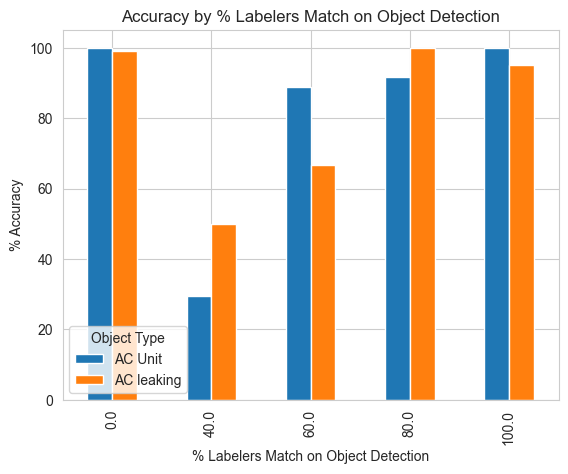

In [1082]:
import matplotlib.pyplot as plt

# Assuming 'accuracy_by_agreement' is your DataFrame
accuracy_by_agreement = accuracy_by_agreement.reset_index()

# Create a pivot table
pivot_table = accuracy_by_agreement.pivot(index='percent_agreement', columns='name', values='percent_accuracy')

# Plot the data
pivot_table.plot(kind='bar', stacked=False)

# Add labels and title
plt.xlabel('% Labelers Match on Object Detection')
plt.ylabel('% Accuracy')
plt.title('Accuracy by % Labelers Match on Object Detection')
legend = plt.legend(title='Object Type', loc='lower left')
# Show the plot
plt.show()

In [1084]:
matched_sets

,image_name_index,image_id,name,num_agree_in_set,set_order,connected_sets,averaged_polygons,percent_agreement
0,0,005FFFAE-CEE1-4488-95D3-E3289B389128.jpeg,AC Unit,5,0,"{POLYGON ((845 574, 867 574, 867 613, 845 613,...","POLYGON ((843 577, 867 577, 867 613, 843 613, ...",100.0
1,1,005FFFAE-CEE1-4488-95D3-E3289B389128.jpeg,AC leaking,4,0,"{POLYGON ((819 578, 868 578, 868 615, 819 615,...","POLYGON ((821 576, 867 576, 867 614, 821 614, ...",80.0
2,2,009FAA0F-631C-4A13-BFE6-678B24DE0044.jpeg,AC Unit,5,0,"{POLYGON ((706 397, 749 397, 749 440, 706 440,...","POLYGON ((709 398, 748 398, 748 439, 709 439, ...",100.0
3,3,009FAA0F-631C-4A13-BFE6-678B24DE0044.jpeg,AC Unit,5,1,"{POLYGON ((732 620, 770 620, 770 654, 732 654,...","POLYGON ((732 621, 770 621, 770 655, 732 655, ...",100.0
4,4,009FAA0F-631C-4A13-BFE6-678B24DE0044.jpeg,AC Unit,5,2,"{POLYGON ((781 461, 813 461, 813 495, 781 495,...","POLYGON ((781 460, 813 460, 813 496, 781 496, ...",100.0
...,...,...,...,...,...,...,...,...
381,381,FB0C8388-3E55-4066-A900-7C3C72A33158.jpeg,AC Unit,5,0,"{POLYGON ((985 356, 1018 356, 1018 380, 985 38...","POLYGON ((984 356, 1015 356, 1015 380, 984 380...",100.0
382,382,FB0C8388-3E55-4066-A900-7C3C72A33158.jpeg,AC leaking,5,0,"{POLYGON ((948 357, 1012 357, 1012 387, 948 38...","POLYGON ((948 356, 1015 356, 1015 388, 948 388...",100.0
383,383,FD8A3406-B6C5-4F6B-8330-EF11CB8DE500.jpeg,AC Unit,5,0,"{POLYGON ((1156 863, 1183 863, 1183 894, 1156 ...","POLYGON ((1157 863, 1183 863, 1183 894, 1157 8...",100.0
384,384,FF43BB35-656F-48AD-BF15-B8B5A6244014.jpeg,AC Unit,5,0,"{POLYGON ((390 257, 421 257, 421 291, 390 291,...","POLYGON ((390 257, 420 257, 420 291, 390 291, ...",100.0


In [ ]:
# Path: image_classification.ipynb


def set_seed(seed):
    # Set the random seed for reproducibility
    import torch
    import numpy as np
    import random
    torch.backends.cudnn.deterministic = True

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def clean_string(s):
    import re
    # Replace all non-alphabetic characters with an empty string
    cleaned_string = re.sub(r'[^a-zA-Z]', '', s)
    # Convert the string to lowercase
    cleaned_string = cleaned_string.lower()
    return cleaned_string


In [1128]:
mask_df
            #print(f'Image {image_id} cropped and saved to {cropped_image_path}')

,image_id,image_path,x,y,w,h
0,347ED694-833B-4F44-ABD9-8A26E9BF12A7_1_201_a.jpeg,../data/images/ac_150_images/347ED694-833B-4F4...,476,460,654,484
1,56E8920C-C46B-4CC9-96CC-178AE00230D3.jpeg,../data/images/ac_150_images/56E8920C-C46B-4CC...,676,394,568,484
2,0AD2D165-CE95-4F5C-BF88-524EA08A686E.jpeg,../data/images/ac_150_images/0AD2D165-CE95-4F5...,688,583,302,214
3,66B175F8-4DAC-4FBA-B8F5-C26711B0C71F.jpeg,../data/images/ac_150_images/66B175F8-4DAC-4FB...,381,185,888,775
4,55CE2555-D78E-49BE-8E89-476C586FEAE1.jpeg,../data/images/ac_150_images/55CE2555-D78E-49B...,647,312,448,527
...,...,...,...,...,...,...
145,B1C7EC79-8557-4E99-B35F-84D865173443.jpeg,../data/images/ac_150_images/B1C7EC79-8557-4E9...,958,265,240,565
146,BE4A6D79-5A14-426D-BE3B-AB1E723C6D1B.jpeg,../data/images/ac_150_images/BE4A6D79-5A14-426...,699,335,823,625
147,95EACEFD-27BD-4C6C-91EE-9F2FC2C55F21.jpeg,../data/images/ac_150_images/95EACEFD-27BD-4C6...,856,266,268,573
148,118B1765-3890-4C35-92B8-6570017F9193.jpeg,../data/images/ac_150_images/118B1765-3890-4C3...,864,354,278,407


In [1120]:
len(image_df[image_df['w'] == 0])

0

In [1137]:
len(matched_sets)

386